In [7]:
!pip install split_folders

In [5]:
import splitfolders

In [3]:
input_folder = "data"
output = "processed_data"
splitfolders.ratio(input_folder, output, seed=42, ratio = (.6, .2, .2))

In [10]:
help(splitfolders.ratio)

Help on function ratio in module splitfolders.split:

ratio(input, output='output', seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)



In [8]:
ls

 Volume in drive D is VAK
 Volume Serial Number is 145A-46F3

 Directory of D:\Osteoporosis Project\ResNet

03/21/2023  10:53 AM    <DIR>          .
03/21/2023  10:53 AM    <DIR>          ..
03/21/2023  10:46 AM    <DIR>          .ipynb_checkpoints
03/21/2023  10:53 AM             1,197 ResNet.ipynb
               1 File(s)          1,197 bytes
               3 Dir(s)  887,267,299,328 bytes free


In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

### Printing Versions of the libraries installed

import tensorflow as tf

import numpy as np

import matplotlib as plt

print(tf.__version__)

print(np.__version__)

print(plt.__version__)

print(splitfolders.__version__)


In [2]:
img_height, img_width = (224, 224)
batch_size = 32

train_data_dir = r"processed_data\train"
valid_data_dir = r"processed_data\val"
test_data_dir = r"processed_data\test"

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.4)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = (img_height, img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'training')

valid_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = (img_height, img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'validation')

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                   target_size = (img_height, img_width),
                                                   batch_size = 1,
                                                   class_mode = 'categorical',
                                                   subset = 'validation')

Found 127 images belonging to 2 classes.
Found 83 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [4]:
x, y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
train_generator.num_classes

2

In [5]:
base_model = ResNet50(include_top = False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(train_generator.num_classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_generator, epochs = 10)

Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 1.9268 - accuracy: 0.5512
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 0.4607 - accuracy: 0.7953
Epoch 3/10
4/4 [==============================] - 6s 2s/step - loss: 0.3948 - accuracy: 0.8425
Epoch 4/10
4/4 [==============================] - 6s 2s/step - loss: 0.2708 - accuracy: 0.8819
Epoch 5/10
4/4 [==============================] - 12s 3s/step - loss: 0.1712 - accuracy: 0.9449
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.1946 - accuracy: 0.9134
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.1937 - accuracy: 0.9213
Epoch 8/10
4/4 [==============================] - 9s 2s/step - loss: 0.1761 - accuracy: 0.9370
Epoch 9/10
4/4 [==============================] - 8s 2s/step - loss: 0.1566 - accuracy: 0.9449
Epoch 10/10
4/4 [==============================] - 7s 2s/step - loss: 0.1198 - accuracy: 0.9606


In [6]:
model.save('saved_models\model8.h5')

In [12]:
test_loss, test_acc = model.evaluate(test_generator, verbose = 2)
print('\nTest Accuracy: ', test_acc)

10/10 - 2s - loss: 1.2420 - accuracy: 0.8000 - 2s/epoch - 170ms/step

Test Accuracy:  0.800000011920929


1/1 [==============================] - 0s 144ms/step


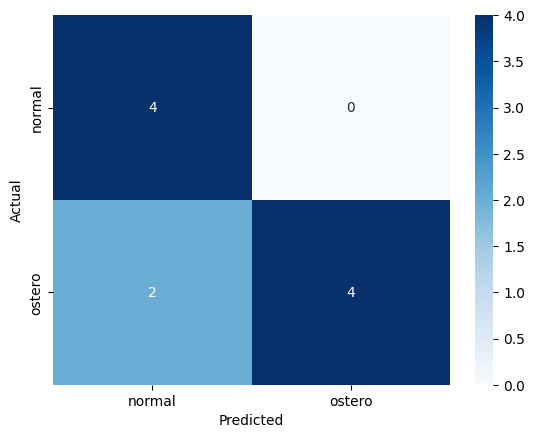

test accuracy : 800


In [13]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('saved_models\model1.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(nb_samples):
    x_test, y_test = test_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns = ['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames = ['Actual'], colnames = ['Predicted'])

sn.heatmap(confusion_matrix, cmap = 'Blues', annot = True, fmt = 'd')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum().sum()*100)))